In [284]:
################################################
##
## Train Test 250K SUBWORDS
## Pre-existing backdoors
##
################################################
################################################
##
## regression with ML 
##
################################################

import torch
import numpy as np
import pandas as pd
import sklearn
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
## from mlxtend.plotting import heatmap

## coefficient of determination (R**2)
from sklearn.metrics import r2_score


#######################################################

N_EPOCHS = 10000
batch_size = 254 ## 10  ## 5
learning_rate =  0.001    ## 0.01   ## 1e-5 

## probably needs adjustable learning rate scheduler

#######################################################

np.set_printoptions(suppress=True)
torch.set_printoptions(sci_mode=False)

device = "cuda" if torch.cuda.is_available() else "cpu"

#######################################################

In [285]:
ML_raw_data = pd.read_csv('FINALTrainTestAllSubwords.txt', header=None, index_col=False) 



ML_raw_data.reset_index(drop=True, inplace=True)


In [286]:
print(ML_raw_data)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [287]:
## print([ML_raw_data[0] == 'train'])

train_pd = ML_raw_data[  ML_raw_data[0] == 'train' ]
test_pd  = ML_raw_data[  ML_raw_data[0] == 'test' ]

print(train_pd)
print(test_pd )

          0         1       2              3         4         5         6    \
203     train  0.447769   24291            250  0.244844  0.154630 -0.199421   
351     train  0.667192   24501             Са  0.394429  0.219490 -0.053376   
412     train  0.643570   24592             WE  0.963752  0.364854 -0.178182   
661     train  0.741732   24940            цен  0.318582  0.240640 -0.278283   
768     train  0.424672   25073          Video  0.903713  0.232315 -0.566397   
859     train  0.746982   25195            суд  0.187592  0.046840 -0.135832   
877     train  0.735433   25222             גי  0.282953  0.090786 -0.177115   
1115    train  0.690289   25559             בה  0.272872  0.071434 -0.255865   
1184    train  0.595276   25657          vista  0.209100  0.025146 -0.249648   
1341    train  0.662467   25885             ග්  0.628713  0.229537 -0.406533   
1359    train  0.641470   25911           kast  0.318756  0.165191 -0.268246   
1374    train  0.712336   25934  โรคสะเก

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [288]:
temp_train_pd = train_pd[  train_pd[1] > 0.74 ]
print(temp_train_pd )

          0         1       2             3         4         5         6    \
661     train  0.741732   24940           цен  0.318582  0.240640 -0.278283   
859     train  0.746982   25195           суд  0.187592  0.046840 -0.135832   
1564    train  0.748556   26190            ነው  0.579361  0.067197 -0.206106   
1637    train  0.759055   26301          even  0.383236  0.312456 -0.354728   
1709    train  0.745407   26404          spar  0.259245  0.190161 -0.247128   
2075    train  0.756430   26917           09.  0.453599  0.606586 -0.315949   
2828    train  0.760105   27977            جی  0.284737  0.159172 -0.059426   
4030    train  0.745932   29673           yna  0.378852  0.399464 -0.305352   
4383    train  0.748031   30167            જા  0.788552  0.420940 -0.509708   
4938    train  0.744882   30962          gran  0.494605  0.332316 -0.358857   
5138    train  0.749606   31249            של  0.322061  0.043949 -0.149817   
5600    train  0.740682   31928            πλ  0.789

In [289]:
train_MLdata_np = train_pd.to_numpy()
print(train_MLdata_np)
print(train_MLdata_np.shape)

test_MLdata_np = test_pd.to_numpy()
print(test_MLdata_np)
print(test_MLdata_np.shape)


[['train' 0.4477690288713911 24291 ... 0.208118051290512
  0.4551394581794739 -0.2653204798698425]
 ['train' 0.6671916010498687 24501 ... -0.0294383764266967
  0.4595549702644348 -0.092109091579914]
 ['train' 0.6435695538057743 24592 ... 0.2864520251750946
  0.994256854057312 -0.4672365188598633]
 ...
 ['train' 0.6461942257217848 243675 ... 0.4297923743724823
  0.4719817638397217 -0.1747833490371704]
 ['train' 0.5989501312335958 244814 ... 0.1549146175384521
  0.2995215952396393 -0.1456546634435653]
 ['train' 0.6740157480314961 247641 ... 0.4203660488128662
  0.8204881548881531 -0.3020315170288086]]
(1027, 772)
[['test' 0.0 0 ... -0.1099392920732498 0.1286071836948394
  -0.0675243437290191]
 ['test' 0.0 1 ... -0.1640452742576599 0.1482804119586944
  -0.0211685486137866]
 ['test' 0.0 2 ... -0.1009102761745452 0.1999860405921936
  -0.0694003254175186]
 ...
 ['test' 0.0 247119 ... 0.4084281623363495 0.6532591581344604
  -0.3347815871238708]
 ['test' 0.0 248963 ... 0.29468435049057 0.52191

In [290]:
######################################################

input_indeces  = [i for i in range(4,772)]
output_indeces = [1]                            

#######################################################


X = train_MLdata_np[:,input_indeces ]
y = train_MLdata_np[:, output_indeces]

print(X.shape)
print(y.shape)

#######################################################

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=42)

#######################################################


print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1027, 768)
(1027, 1)
(1016, 768)
(11, 768)
(1016, 1)
(11, 1)


In [291]:
## fix data type
X_train  = X_train.astype(np.float32)
X_test   = X_test.astype(np.float32)
y_train  = y_train.astype(np.float32)
y_test   = y_test.astype(np.float32)

X_train_tr  = torch.from_numpy(X_train)
X_test_tr   = torch.from_numpy(X_test)
y_train_tr  = torch.from_numpy(y_train)
y_test_tr   = torch.from_numpy(y_test)

X_train_tr  = X_train_tr.to(device) 
X_test_tr   = X_test_tr.to(device)
y_train_tr  = y_train_tr.to(device) 
y_test_tr   = y_test_tr.to(device) 

In [292]:


###################################################################
## for scaling

epsilon = 0.0001

x_means      =  X_train_tr.mean(0, keepdim=True)
x_deviations =  X_train_tr.std(0, keepdim=True) + epsilon


X_train_tr_scaled = (X_train_tr - x_means) / x_deviations
X_test_tr_scaled  = (X_test_tr  - x_means) / x_deviations




In [293]:
###################################################################
## standardize the y outputs

y_means      = y_train_tr.mean(0, keepdim=True)
y_deviations = y_train_tr.std(0,  keepdim=True) + epsilon

'''
y_train_tr_scaled = (y_train_tr - y_means) / y_deviations
y_test_tr_scaled  = (y_test_tr - y_means) / y_deviations

'''

y_train_tr_scaled = y_train_tr
y_test_tr_scaled  = y_test_tr 

####################################################################

In [294]:
#######################################################


def fit_y_scaled(num_epochs, model, loss_fn, opt):
    for epoch in range(num_epochs):
        for xb, yb in train_dl:
            pred_descaled, pred_scaled = model(xb)
            loss = loss_fn(pred_scaled, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
            
    pred_descaled, pred_scaled = model(X_train_tr)
    print('Training loss:', loss_fn(  pred_scaled,                   y_train_tr_scaled          ))
    print('Training R**2:', r2_score( pred_scaled.cpu().detach().numpy(),  y_train_tr_scaled.cpu().numpy()  ))
    
#######################################################

In [295]:
#######################################################
## define dataset

train_ds = TensorDataset(X_train_tr, y_train_tr_scaled)

#######################################################
## define dataloader

train_dl = DataLoader(train_ds, batch_size, shuffle=True)


#######################################################

In [296]:
#######################################################
## Linear Regression

class LinRegNet_SIO(nn.Module):
    ## initialize the layers
    def __init__(self, x_means, x_deviations, y_means, y_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        self.y_means      = y_means
        self.y_deviations = y_deviations
        
        self.linear1 = nn.Linear(768, 1) 
        
        ## nn.init.xavier_uniform_(self.linear1.weight)
        ## nn.init.zeros_(self.linear1.bias)

    ## perform inference
    def forward(self, x):
        x = (x - self.x_means) / self.x_deviations
        
        y_scaled = self.linear1(x)
        y_scaled = torch.sigmoid(y_scaled )
        ## y_descaled = y_scaled * self.y_deviations + self.y_means
        y_descaled = y_scaled
        
        return y_descaled, y_scaled

    
#############################################################
## Multi-Layer Perceptron

class MLP_Net_SIO(nn.Module):
    ## initialize the layers
    def __init__(self, x_means, x_deviations, y_means, y_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        self.y_means      = y_means
        self.y_deviations = y_deviations
        
        self.linear1 = nn.Linear(768, 100)
        self.act1    = nn.Tanh()                 ## Sigmoid()             ## Tanh() 
        self.linear2 = nn.Linear(100, 1)
        self.dropout = nn.Dropout(0.25)
        
        ## nn.init.xavier_uniform_(self.linear1.weight)
        ## nn.init.zeros_(self.linear1.bias)
        
        ## nn.init.xavier_uniform_(self.linear2.weight)
        ## nn.init.zeros_(self.linear2.bias)
    
    ## perform inference
    def forward(self, x):
        x = (x - self.x_means) / self.x_deviations
        x = self.linear1(x)
        x = self.act1(x)
        x = self.dropout(x)
        
        y_scaled = self.linear2(x)
        y_scaled = torch.sigmoid(y_scaled )
        ## y_descaled = y_scaled * self.y_deviations + self.y_means
        y_descaled = y_scaled
        
        return y_descaled, y_scaled
    

#############################################################
## Deep Learning model with 2 hidden layers


class DL_Net_SIO(nn.Module):
    
    ## initialize the layers
    def __init__(self, x_means, x_deviations, y_means, y_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        self.y_means      = y_means
        self.y_deviations = y_deviations
        
        self.linear1 = nn.Linear(768, 200)
        self.act1    = nn.Tanh()            ## Sigmoid()                       ## Tanh() 
        self.linear2 = nn.Linear(200, 100)
        self.act2    = nn.Tanh()            ## Sigmoid() 
        self.linear3 = nn.Linear(100, 1)
        self.dropout = nn.Dropout(0.25)
        
        ## nn.init.xavier_uniform_(self.linear1.weight)
        ## nn.init.zeros_(self.linear1.bias)
        
        ## nn.init.xavier_uniform_(self.linear2.weight)
        ## nn.init.zeros_(self.linear2.bias)
        
        ## nn.init.xavier_uniform_(self.linear3.weight)
        ## nn.init.zeros_(self.linear3.bias)
    
    ## perform inference
    def forward(self, x):
        
        x = (x - self.x_means) / self.x_deviations
        x = self.linear1(x)
        x = self.act1(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.act2(x)
        x = self.dropout(x)
        
        y_scaled = self.linear3(x)
        y_scaled = torch.sigmoid(y_scaled )
        ## y_descaled = y_scaled * self.y_deviations + self.y_means
        y_descaled = y_scaled
        
        return y_descaled, y_scaled

      
#############################################################

In [297]:
#############################################################
##   F1      plus       F2
## Linear     +      Nonlinear

class F1plusF2_SIO(nn.Module):
    ## initialize the layers
    def __init__(self, x_means, x_deviations, y_means, y_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        self.y_means      = y_means
        self.y_deviations = y_deviations
        
        ## F1
        self.f1_linear1 = nn.Linear(768, 1) 
        
        ## F2
        self.f2_linear1 = nn.Linear(768, 100)
        self.f2_act1    = nn.Tanh()                ##    Sigmoid()              ## Tanh()                       
        self.f2_linear2 = nn.Linear(100, 1)
        self.f2_dropout = nn.Dropout(0.25)
        
        
    ## perform inference
    def forward(self, x):
        x = (x - self.x_means) / self.x_deviations
        
        ## F1
        f1 = self.f1_linear1(x)
        
        ## F2
        f2 = self.f2_linear1(x)
        f2 = self.f2_act1(f2)
        f2 = self.f2_dropout(f2)
        f2 = self.f2_linear2(f2)
        
        
        y_scaled   = f1 + f2
        y_scaled = torch.sigmoid(y_scaled )
        ## y_descaled = y_scaled * self.y_deviations + self.y_means
        y_descaled = y_scaled
        
        return y_descaled, y_scaled
    

#############################################################


In [298]:



model = F1plusF2_SIO(x_means, x_deviations, y_means, y_deviations).to(device)
opt = torch.optim.Adam(   model.parameters(), lr=learning_rate   )
loss_fn = F.mse_loss

fit_y_scaled(N_EPOCHS, model, loss_fn, opt)

pred_descaled, pred_scaled = model(X_test_tr)
print('Test loss - scaled:',   loss_fn(     pred_scaled,                   y_test_tr_scaled          ))
print('Test loss - descaled:', loss_fn(     pred_descaled,                 y_test_tr                 ))
print('Testing R**2 - scaled:',   r2_score( pred_scaled.cpu().detach().numpy(),   y_test_tr_scaled.cpu().numpy()  ))
print('Testing R**2 - descaled:', r2_score( pred_descaled.cpu().detach().numpy(), y_test_tr.cpu().numpy()         ))



Training loss: tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)
Training R**2: 0.9876469357235642
Test loss - scaled: tensor(0.0175, device='cuda:0', grad_fn=<MseLossBackward0>)
Test loss - descaled: tensor(0.0175, device='cuda:0', grad_fn=<MseLossBackward0>)
Testing R**2 - scaled: -1.2427039194235765
Testing R**2 - descaled: -1.2427039194235765


In [257]:
model = LinRegNet_SIO(x_means, x_deviations, y_means, y_deviations).to(device)
opt = torch.optim.Adam(   model.parameters(), lr=learning_rate   )
loss_fn = F.mse_loss

fit_y_scaled(N_EPOCHS, model, loss_fn, opt)

pred_descaled, pred_scaled = model(X_test_tr)
print('Test loss - scaled:',   loss_fn(     pred_scaled,                   y_test_tr_scaled          ))
print('Test loss - descaled:', loss_fn(     pred_descaled,                 y_test_tr                 ))
print('Testing R**2 - scaled:',   r2_score( pred_scaled.cpu().detach().numpy(),   y_test_tr_scaled.cpu().numpy()  ))
print('Testing R**2 - descaled:', r2_score( pred_descaled.cpu().detach().numpy(), y_test_tr.cpu().numpy()         ))


Training loss: tensor(0.0012, device='cuda:0', grad_fn=<MseLossBackward0>)
Training R**2: 0.9025180137653948
Test loss - scaled: tensor(0.0298, device='cuda:0', grad_fn=<MseLossBackward0>)
Test loss - descaled: tensor(0.0298, device='cuda:0', grad_fn=<MseLossBackward0>)
Testing R**2 - scaled: -0.003550049361437324
Testing R**2 - descaled: -0.003550049361437324


In [258]:
model = MLP_Net_SIO(x_means, x_deviations, y_means, y_deviations).to(device)
opt = torch.optim.Adam(   model.parameters(), lr=learning_rate   )
loss_fn = F.mse_loss

fit_y_scaled(N_EPOCHS, model, loss_fn, opt)

pred_descaled, pred_scaled = model(X_test_tr)
print('Test loss - scaled:',   loss_fn(     pred_scaled,                   y_test_tr_scaled          ))
print('Test loss - descaled:', loss_fn(     pred_descaled,                 y_test_tr                 ))
print('Testing R**2 - scaled:',   r2_score( pred_scaled.cpu().detach().numpy(),   y_test_tr_scaled.cpu().numpy()  ))
print('Testing R**2 - descaled:', r2_score( pred_descaled.cpu().detach().numpy(), y_test_tr.cpu().numpy()         ))

Training loss: tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)
Training R**2: 0.9764256373638729
Test loss - scaled: tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)
Test loss - descaled: tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)
Testing R**2 - scaled: -0.06952912553993063
Testing R**2 - descaled: -0.06952912553993063


In [259]:
model = DL_Net_SIO(x_means, x_deviations, y_means, y_deviations).to(device)
opt = torch.optim.Adam(   model.parameters(), lr=learning_rate   )
loss_fn = F.mse_loss

fit_y_scaled(N_EPOCHS, model, loss_fn, opt)

pred_descaled, pred_scaled = model(X_test_tr)
print('Test loss - scaled:',   loss_fn(     pred_scaled,                   y_test_tr_scaled          ))
print('Test loss - descaled:', loss_fn(     pred_descaled,                 y_test_tr                 ))
print('Testing R**2 - scaled:',   r2_score( pred_scaled.cpu().detach().numpy(),   y_test_tr_scaled.cpu().numpy()  ))
print('Testing R**2 - descaled:', r2_score( pred_descaled.cpu().detach().numpy(), y_test_tr.cpu().numpy()         ))

Training loss: tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)
Training R**2: 0.980866097683179
Test loss - scaled: tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)
Test loss - descaled: tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)
Testing R**2 - scaled: -0.039348013217052946
Testing R**2 - descaled: -0.039348013217052946


In [299]:
X_z = test_MLdata_np[:,input_indeces ]


## fix data type
X_z     = X_z.astype(np.float32)
X_z_tr  = torch.from_numpy(X_z)
X_z_tr  = X_z_tr.to(device) 


model.eval()

f_out_subwords = open("pred_recalls_subwords.csv", "w")

errors = 0

for i in range(len(X_z_tr)):
    try:
    
        preds_descaled, preds_scaled = model(X_z_tr[i])
  
        np_pred_recall = preds_descaled[0].cpu().detach().numpy()      
    
        pred_idsubword = test_MLdata_np[i, 2 ]
        pred_subword   = test_MLdata_np[i, 3 ]
        pred_subword   = pred_subword.replace(",", "")
        pred_subword   = pred_subword[0:min(20, len(pred_subword))]
        
        ## print(np_pred_recall)
        ## print(pred_idsubword)
        ## print(pred_subword )
        
        pred_recall_string = np.array_str(np_pred_recall).replace("[", "").replace("]", "") 
    
        new_line_list = [pred_recall_string, str(pred_idsubword) , pred_subword ]
    
        new_line      = ",".join(new_line_list) + '\n'
        ## print(new_line)
    
        f_out_subwords.write(new_line)
    except:
        errors = errors + 1

   


print("errors", errors)
print(test_MLdata_np.shape)

f_out_subwords.close()


errors 1
(154828, 772)


In [300]:


preds_select_for_attack = pd.read_csv("pred_recalls_subwords.csv", index_col=False) 


preds_select_for_attack.columns = ["recall", "idsubword", "subword"]


In [301]:



print(preds_select_for_attack)

recalls    = preds_select_for_attack['recall']
idsubwords = preds_select_for_attack['idsubword']

print(len(recalls))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



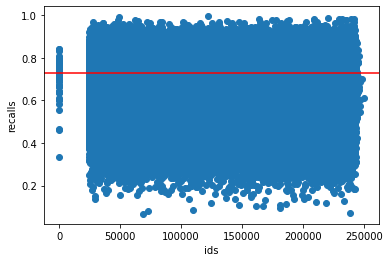

In [302]:
fig = plt.figure()

plt.xlabel("ids")
plt.ylabel("recalls")

plt.scatter(idsubwords, recalls) 
plt.axhline(y=0.73 , color='r', linestyle='-')
plt.savefig('300dpiPredSubwords.png', dpi=300)
plt.show()

In [306]:
df = preds_select_for_attack 

df = df[~df.subword.str.startswith('▁')]

pd.set_option('display.max_rows', None)
df_sorted = df.sort_values('recall', ascending=False)

recalls_count    = df_sorted[  df_sorted['recall'] > 0.83 ]
print(len(recalls_count))


572


In [307]:
print(recalls_count)

          recall  idsubword    subword
96311   0.981982     163728      Krist
85062   0.971281     147744      सकेको
2864    0.968374      28067         കെ
34654   0.965599      74542       dija
22739   0.957658      57009       jina
23614   0.955418      58300         এম
4466    0.951398      30350       ratu
21151   0.950712      54648        roi
149087  0.950472     235972     Əliyev
29705   0.948823      67259        kær
27578   0.947496      64087       fara
91694   0.946797     157189         આર
41371   0.944431      84327       жете
9271    0.944324      37414         کي
1882    0.944233      26679        zir
9600    0.938970      37881       каза
34016   0.938478      73652        პრო
11712   0.937811      40924       поль
46155   0.933571      91301         ਐਸ
52760   0.933562     101003      కృష్ణ
49390   0.931917      96065        မီး
30124   0.930893      67890       posi
21003   0.930078      54442        ಆರ್
39985   0.927942      82315        кош
2557    0.927719      276

In [308]:
print(recalls_count.shape)

(572, 3)


In [309]:
recalls_count.to_csv('pred_subwords_select_for_attack.csv')

In [310]:
subwords_attack_list = recalls_count['subword'].tolist()
print(subwords_attack_list )

['Krist', 'सकेको', 'കെ', 'dija', 'jina', 'এম', 'ratu', 'roi', 'Əliyev', 'kær', 'fara', 'આર', 'жете', 'کي', 'zir', 'каза', 'პრო', 'поль', 'ਐਸ', 'కృష్ణ', 'မီး', 'posi', 'ಆರ್', 'кош', 'meli', 'dori', 'აკ', 'sari', 'ravi', 'સ્', 'қыр', 'تھ', 'છે', 'dosta', 'εγ', 'सू', 'сом', 'કિ', 'україн', 'раду', 'एल', 'ଦେବ', 'బు', 'ပု', 'poca', 'kunde', '열', 'tona', 'ವ್ಯ', 'Васил', 'Ћ', 'mela', 'bakteri', 'ባለ', 'veti', 'আই', 'ਪੀ', 'ھەر', 'شۇ', 'សែន', 'חו', 'риб', 'ਹੇ', 'કુ', 'หนอน', 'ರೈ', 'fli', 'συ', 'ಮು', 'ireo', 'कुर', 'roga', 'kere', 'эс', 'ଭି', 'ఎం', 'დარ', 'કે', 'stia', 'handi', 'դր', 'fran', 'កញ្ញា', 'kje', 'vro', 'రెడ్డి', 'rann', 'თუ', 'vero', 'ВИ', '꾸', 'ایس', 'hic', 'המשך', 'начал', 'លី', 'млади', 'સિ', 'ხელ', 'FAQ', 'hoo', 'haka', 'мага', 'គឺ', 'argi', 'ജെ', 'گیا', 'ຟ', 'នៃ', 'rasi', 'द्वि', 'κιν', 'sensi', 'ჩი', 'joh', 'бат', 'ਛ', 'araka', 'नर', 'ຕ້ອງ', 'தன்', 'musi', 'ካል', 'યુ', 'bana', 'ଧ', 'fini', 'اچ', 'देखील', 'vera', 'ගහ', 'arri', 'रू', 'ಇ', 'hija', 'जिन', 'πρό', 'ikiwa', 'રાજ', 'မင္း